In [1]:
import sys
sys.path.append('..')
from src.datasets import get_dataset

dat = get_dataset(dataset_name='salient_imagenet', data_dir=None, class_idxs=[306, 142, 270, 319, 366, 389])
                  #[1, 55, 601, 306, 569, 27, 31, 45, 77, 103, 141, 142, 175, 196, 202, 230, 231, 239, 247, 251, 252, 262, 264])
# 306: beetle -- hands
# 103: platypus (fish?) -- water
# 142: dowitcher (water bird) -- water
# 202: terrier -- hands?
# 264: Corgi -- fence?
# 270: alaskan wolf -- fence?
# 319: dragon fly -- green background
# 366: gorilla -- green background
# 389: snork fish -- person holding the fish

Read /scratch/vp421/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
Read /scratch/vp421/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
[1581] [1941, 1247, 1326, 1390] 306
[925, 1468] [1500, 427, 957] 142
[1401] [1065, 151, 2004, 6] 270
[1797] [402, 754, 1178, 1390] 319
[665] [1317, 490, 960, 797] 366
[778] [686, 59, 449, 227] 389


In [2]:
len(dat)

445

(224, 224, 3) (224, 224, 1)


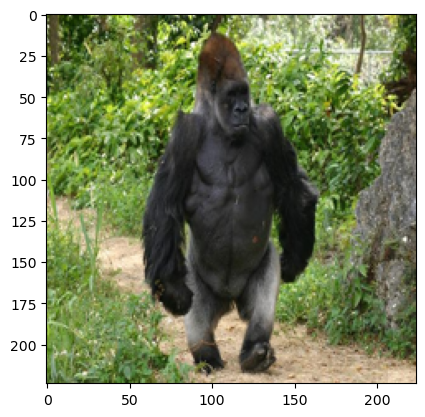

255 0.9882353


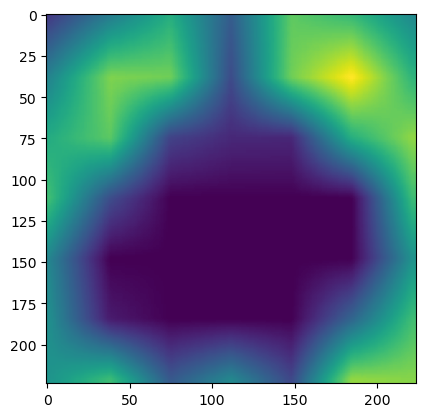

(224, 224, 3) (224, 224, 1)


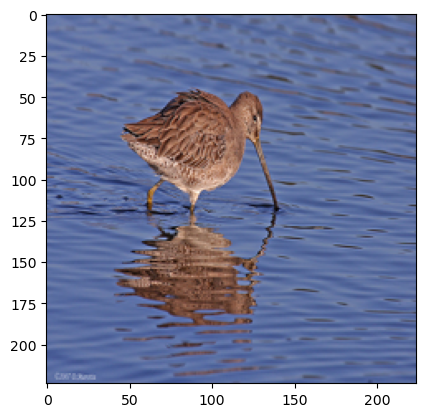

255 0.99607843


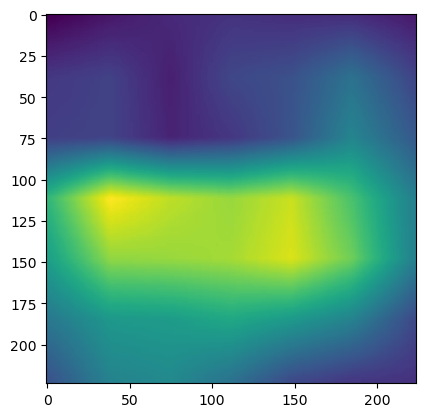

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import torch

for _ in range(2):
    idx = np.random.choice(len(dat))
    img, y, mask, g = dat[idx]
    print(img.shape, mask.shape)
    plt.imshow(img)
    plt.show()
    plt.imshow(mask) #torch.permute(mask, [1, 2, 0]))
    print(img.max(), mask.max())
    plt.show()

## Evaluate with noise
Computes RCS (Relative Core Sentivity) value, which is a metric defined in https://arxiv.org/pdf/2203.15566.   
Requires the trained model checkpoint.    
Caution: the code is unaware of the config, which means it could use a network different from what is defined through the config kwarg.     

In [3]:
import sys
sys.path.append('..')
from src.networks import get_network
from src.datasets import get_dataset, data_module

import torch
import os
    
dm = data_module.DataModule(dataset='salient_imagenet', data_dir=None, 
                            dataset_kwargs={'class_idxs': [306, 142, 270, 319, 366, 389]},
                            data_seed=0, data_frac=-1, batch_size_test=64, num_workers=1)
dm2 = data_module.DataModule(dataset='salient_imagenet', data_dir=None, 
                            dataset_kwargs={'class_idxs': [306, 142, 270, 319, 366, 389], 'core': True},
                            data_seed=0, data_frac=-1, batch_size_test=64, num_workers=1)
test_dl = dm.test_dataloader()
test_dl2 = dm2.test_dataloader()

Read /scratch/vp421/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
Read /scratch/vp421/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
[1581] [1941, 1247, 1326, 1390] 306
[925, 1468] [1500, 427, 957] 142
[1401] [1065, 151, 2004, 6] 270
[1797] [402, 754, 1178, 1390] 319
[665] [1317, 490, 960, 797] 366
[778] [686, 59, 449, 227] 389
Read /scratch/vp421/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
Read /scratch/vp421/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
[1581] [1941, 1247, 1326, 1390] 306
[925, 1468] [1500, 427, 957] 142
[1401] [1065, 151, 2004, 6] 270
[1797] [402, 754, 1178, 1390] 319
[665] [1317, 490, 960, 797] 366
[778] [686, 59, 449, 227] 389


In [25]:
for _i in [0, 2, 3, 4, 5, 6]:
    fldr = f"/scratch/vp421/cache/ibp_explanations/IBP2/IBP2-{1703+_i}"
    name = [name for name in os.listdir(fldr) if name.startswith('checkpt')][0]
    ckpt_name = f"{fldr}/{name}"
    net = get_network('resnet18', network_kwargs={'num_classes': 6})
    dat = get_dataset(dataset_name='salient_imagenet', data_dir=None, class_idxs=[306, 142, 270, 319, 366, 389])
    # print(f"Loading from {ckpt_name}")

    with open(ckpt_name, "rb") as f:
        sd = torch.load(f)['state_dict']
        sd_ = {k.replace('model.', ''): sd[k] for k in sd}
        net.load_state_dict(sd_)
    corrs, ncorrs, N = 0, 0, 0
    for batch_x, batch_y, batch_mask, batch_g in test_dl:
        noise = torch.randn(size=batch_x.shape)*2
        with torch.no_grad():
            pred_y = torch.argmax(net(batch_x), dim=-1)
            noisy_preds = torch.argmax(net(batch_x + noise*batch_mask), dim=-1)
            corrs += (pred_y == batch_y).sum()
            ncorrs += (noisy_preds == batch_y).sum()
            N += len(pred_y)

    acc1, spu_acc = corrs/N, ncorrs/N
    # print(acc1, spu_acc, N, corrs, ncorrs)
    # print(batch_x.abs().max(), batch_mask.max())
    print(f"{acc1*100:0.2f}, {spu_acc*100:0.2f}, {100*(acc1 - spu_acc)/acc1:0.2f}")

    corrs, ncorrs, N = 0, 0, 0
    for batch_x, batch_y, batch_mask, batch_g in test_dl2:
        noise = torch.randn(size=batch_x.shape)*2
        with torch.no_grad():
            pred_y = torch.argmax(net(batch_x), dim=-1)
            noisy_preds = torch.argmax(net(batch_x + noise*batch_mask), dim=-1)
            corrs += (pred_y == batch_y).sum()
            ncorrs += (noisy_preds == batch_y).sum()
            N += len(pred_y)

    acc1, core_acc = corrs/N, ncorrs/N
    print(core_acc)
    avg_acc = (core_acc + spu_acc)/2

    # we make a slightly different calculation. Core and spurious accuracies are obtained by perturbing core and spurious masks instead of perturbing 1-core and 1-spurious masks as proposed in the original paper. 
    # Approximating the obtained core_acc as 1-core_acc (that we would have gotten if we had perturbed 1-core_mask), similarly for spu_acc, we report RCS as spu_acc-core_acc/denominator.
    print("RCS:", (core_acc - spu_acc)/(2*min(avg_acc, 1-avg_acc)))

Read /scratch/vp421/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
Read /scratch/vp421/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
[1581] [1941, 1247, 1326, 1390] 306
[925, 1468] [1500, 427, 957] 142
[1401] [1065, 151, 2004, 6] 270
[1797] [402, 754, 1178, 1390] 319
[665] [1317, 490, 960, 797] 366
[778] [686, 59, 449, 227] 389
96.43, 89.29, 7.41
tensor(0.6960)
RCS: tensor(-0.4788)
Read /scratch/vp421/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
Read /scratch/vp421/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
[1581] [1941, 1247, 1326, 1390] 306
[925, 1468] [1500, 427, 957] 142
[1401] [1065, 151, 2004, 6] 270
[1797] [402, 754, 1178, 1390] 319
[665] [1317, 490, 960, 797] 366
[778] [686, 59, 449, 227] 389
95.54, 89.29, 6.54
tensor(0.6557)
RCS: tensor(-0.5254)
Read /scratch/vp421/salient_imagenet_dataset/discover_spurious_features.csv and read 5000 answers
Read /

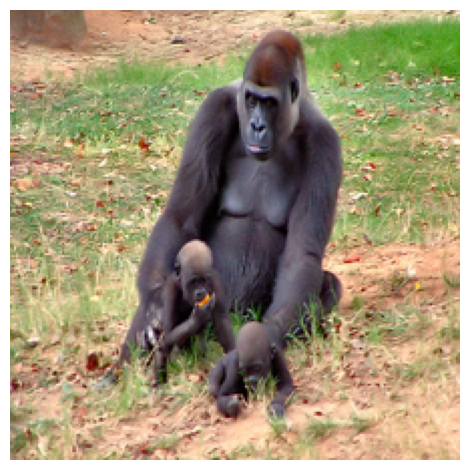

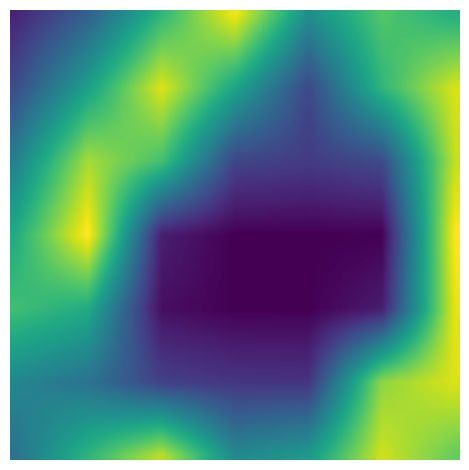

In [20]:
from torchvision import transforms as T

for batch_x, batch_y, batch_mask, batch_g in dm.test_dataloader():
    idx = 1
    x, mask = batch_x[idx], batch_mask[idx]
    mean, std = torch.tensor([0.485, 0.456, 0.406]).view([3, 1, 1]), torch.tensor([0.229, 0.224, 0.225]).view([3, 1, 1])
    x = x*std + mean
    # mask = mask*std + mean
    x, mask = T.ToPILImage("RGB")(x), T.ToPILImage("L")(mask)
    plt.imshow(x)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("plots/simagenet_ex1.png")
    plt.show()
    
    plt.imshow(mask)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("plots/simagenet_mask1.png")
    plt.show()
    break